In [ ]:
# waiting for the lens API so will use the old data and manually clean what is being added to it

In [269]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import requests
import os 
import numpy as np
os.chdir('/Users/jmccarty/GitHub/urban_bipv_annotated_bib')


In [208]:
# original data from lens query with the remove columns
orig_data = pd.read_csv('/Users/jmccarty/GitHub/urban_bipv_annotated_bib/data/raw_query_manual_clean.csv',index_col=0)
orig_data['Remove'] = orig_data['Remove'].fillna(False)
orig_data['data_source'] = 'Long'


# original data from lens query without the removed column but with language data
orig_data_lang = pd.read_csv('/Users/jmccarty/GitHub/urban_bipv_annotated_bib/data/archive/lit_dataset_all.csv',index_col=0)

# orig data from lens query with affiliation and has been filtered but no language
orig_data_filt = pd.read_csv('/Users/jmccarty/GitHub/urban_bipv_annotated_bib/data/clean_affiliated_filtered.csv',index_col=0)
id_keep_list = orig_data_filt.index.tolist()

# the list of IDs that I want to keep after removing thermal from the query
short_query = pd.read_csv('/Users/jmccarty/GitHub/urban_bipv_annotated_bib/data/raw_query_short.csv',index_col=0)
new_id_keep_list = short_query.index.tolist()


# data = orig_data_lang[orig_data_lang.index.isin(id_keep_list)==True]
# orig_data_filt['language'] = data['language']





In [ ]:
# first filter the original query for the items we want from the short query
df = orig_data[orig_data.index.isin(new_id_keep_list)==True].copy()

df['Publication Type'] = df['Publication Type'].fillna('None')
df.shape

In [ ]:
# next add the missing items; the new items in the short query back in
# there are some in the shortlist that are not in the long list but should be kept...
# print titles to review whether they are relevant or not like I did in the manual cleaning step
data_missing = short_query[short_query.index.isin(orig_data.index.tolist())==False].copy()

# for title in data_missing.Title.tolist():
#     print(f'--> {title}')
# for idx in data_missing.index.tolist():
#     print(f'--> {idx}')
for ii in list(range(0,len(data_missing))):
    print(f'--> LensID: {data_missing.iloc[ii].name}')
    print(data_missing.iloc[ii].Title)

In [ ]:
# check the print out to see if you want to remove any of those based on general relevance
data_missing = data_missing.drop(index='105-717-334-856-892')

# add a remove and data_source field to match the shape of the full df
data_missing['Remove'] = False
data_missing['data_source'] = 'Short'

# combine them
df_short = pd.concat([df,data_missing])

In [ ]:
# now we need to grab the language field that was created and add it to the dataset
corpus_items = df.index.tolist()
lang_df = orig_data_lang[orig_data_lang.index.isin(corpus_items)==True]['language']
df_short = df_short.join(lang_df)


In [ ]:
# save it out to add language to the newly added items
# be sure to skip the items from the Long dataset
df_short.to_csv(os.path.join(os.getcwd(),'data','manual_edits','cluster_data_missingLang.csv'))

In [ ]:
# after adding the languages bring it back
df_short_lang = pd.read_csv(os.path.join(os.getcwd(),'data','manual_edits','cluster_data_addedLang.csv'))
df_short_lang.head()

In [ ]:
# now we move the filtering
# RELEVANCE

df_short_lang_rel = df_short_lang[df_short_lang['Remove']==False]


print(f'Original shape was {df_short_lang.shape}')
print(f'New shape is {df_short_lang_rel.shape}')

irrel = len(df_short_lang) - len(df_short_lang_rel)
print(f'Total irrelevant items in corpus: {irrel}')


In [ ]:
# LANGUAGE

pd.value_counts(df_short_lang_rel['language']).plot.bar()

df_short_lang_rel_en = df_short_lang_rel[df_short_lang_rel['language']=='en']

non_en = len(df_short_lang_rel) - len(df_short_lang_rel_en)
print(f'Total nonenglish items in corpus: {non_en}')
print(df_short_lang_rel.groupby('language')['Lens ID'].nunique().sort_values())



In [ ]:
# ABSTRACT

df_short_lang_rel_en_ab = df_short_lang_rel_en[~df_short_lang_rel_en['Abstract'].isnull()]

no_ab = len(df_short_lang_rel_en) - len(df_short_lang_rel_en_ab)
print(f'Total no abstract items in corpus: {no_ab}')


In [ ]:
# TITLES

df_short_lang_rel_en_ab_ti = df_short_lang_rel_en_ab[~df_short_lang_rel_en_ab['Title'].isnull()]

no_ti = len(df_short_lang_rel_en_ab) - len(df_short_lang_rel_en_ab_ti)
print(f'Total no abstract items in corpus: {no_ti}')



In [ ]:
# EXTERNAL URL

df_short_lang_rel_en_ab_ti_url = df_short_lang_rel_en_ab_ti[~df_short_lang_rel_en_ab_ti['External URL'].isnull()].copy()

no_url = len(df_short_lang_rel_en_ab_ti) - len(df_short_lang_rel_en_ab_ti_url)
print(f'Total no URL items in corpus: {no_url}')




In [ ]:
df_short_lang_rel_en_ab_ti_url['Publication Type'].unique()

In [ ]:
# EXTERNAL URL BAD
# This takes awhile to run
def check_url(url,pub_type):
    if pub_type=='None':
        try:
            req = requests.get(url, stream=True).status_code
        except:
            req = 'Fail' 
        return req
    else:
        return 'Pass'

df_short_lang_rel_en_ab_ti_url['status'] = df_short_lang_rel_en_ab_ti_url.apply(lambda x: check_url(x['External URL'],
                                                                                                   x['Publication Type']),axis=1)

In [ ]:
# TITLE DUPLICATES
# keep last (maybe a correction occured)


df_short_lang_rel_en_ab_ti_url_dup = df_short_lang_rel_en_ab_ti_url[~df_short_lang_rel_en_ab_ti_url['Title'].str.lower().duplicated(keep='last')].copy()

no_dup = len(df_short_lang_rel_en_ab_ti_url) - len(df_short_lang_rel_en_ab_ti_url_dup)
print(f'Total duplicated items removed from corpus: {no_dup}')

df_short_lang_rel_en_ab_ti_url_dup['Publication Type'].unique()

In [ ]:
# FILL PUBLICATION TYPES
# grabbed the missing items and found them with Zotero 
# using the Zotero JS client I was able to download the majority of them from External URL and get missing fields
# now load those datasets and add them to the df

df_zotero = pd.read_csv(os.path.join(os.getcwd(),'data','manual_edits','zotero_links.csv'))

zot_title_list = df_zotero['Title'].values.tolist()
zot_title_list_lower = df_zotero['Title'].str.lower().values.tolist()


def matchinlist(name,orig_type,zot_list_lower,df_zot):
    if orig_type=='None':
        if name.lower() in zot_list_lower:
            entry = df_zot[df_zot['Title']==name]['Item Type'].values.tolist()
            if len(entry)==0:
                pass
            else:
                return correctzotnames(entry[0])
        else:
            pass
    else:
        return orig_type
        
def correctzotnames(types):
    if types=='conferencePaper':
        return 'conference proceedings'
    elif types=='journalArticle':
        return 'journal article'
    elif types=='report':
        return 'report'
    elif types=='webpage':
        return 'webpage'
    elif types=='book':
        return 'book'
    elif types=='bookSection':
        return 'book chapter'
    elif types=='presentation':
        return 'presentation'
    elif types=='thesis':
        return 'dissertation'
    elif types=='document':
        return 'document'
    else:
        return types
        
pub_types = df_short_lang_rel_en_ab_ti_url_dup.apply(lambda x: matchinlist(x['Title'],
                                                                          x['Publication Type'],
                                                                          zot_title_list_lower,
                                                                          df_zotero),axis=1)
df_short_lang_rel_en_ab_ti_url_dup['publication_type'] = pub_types

In [ ]:
df_short_lang_rel_en_ab_ti_url_dup.head()

In [ ]:
# save it out to add publication types the missing fields
df_short_lang_rel_en_ab_ti_url_dup.to_csv(os.path.join(os.getcwd(),'data','manual_edits','cluster_data_missingPubs.csv'))

In [212]:
# after fixing blank years, languages, publication types bring it back
dataframe = pd.read_csv(os.path.join(os.getcwd(),'data','manual_edits','cluster_data_addedPubs.csv'),index_col='Lens ID')


In [218]:
dataframe = dataframe.join(orig_data_filt['affiliation'])

In [227]:
dataframe = dataframe.replace({'publication_type': 'conference proceedings'}, 'conference article')
dataframe = dataframe.replace({'publication_type': 'conference proceedings article'}, 'conference article')

Total non peer reviwed items removed from corpus: 263


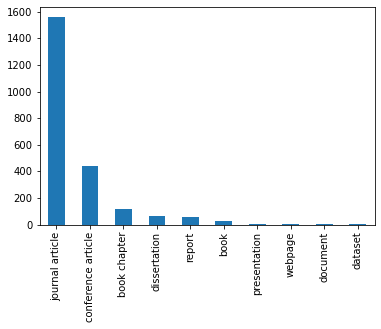

In [229]:
# PUBLICATION TYPE
# remove the non peer reviewed documents

pd.value_counts(dataframe['publication_type']).plot.bar()

dataframe_peer = dataframe[(dataframe['publication_type']=='journal article') | \
                           (dataframe['publication_type']=='conference article')]
  
peer = len(dataframe) - len(dataframe_peer)
print(f'Total non peer reviwed items removed from corpus: {peer}')

In [244]:
cols = ['Title',
        'Publication Year',
        'Abstract',
        'Fields of Study',
        'External URL',
        'publication_type',
        'affiliation']
cluster_df =  dataframe_peer[cols].rename(columns={'Title':'title',
                                                   'Publication Year':'publication_year',
                                                   'Abstract':'abstract',
                                                   'Fields of Study':'tags',
                                                   'External URL':'url'})
cluster_df = cluster_df.astype({'title':'string',
                               'publication_year':'int',
                               'abstract':'string',
                               'tags':'string',
                               'url':'string',
                               'publication_type':'string',
                               'affiliation':'string',})

### Looking At Final Dataset

<AxesSubplot:>

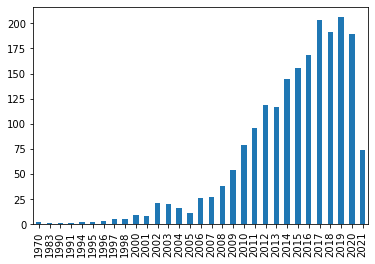

In [255]:
cluster_df.publication_year.value_counts().sort_index().plot.bar()

In [262]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="my_user_agent")

In [263]:
def retrieve_country_code(search_term):
  loc = geolocator.geocode(search_term, exactly_one=False)
  try:
    code = geolocator.reverse([loc[0].latitude, loc[0].longitude]).raw['address']['country_code']
  except TypeError:
    code = 'error'
  return code

In [266]:
test_affil = cluster_df['affiliation'].tolist()[0:4]

for ii in test_affil:
    code = retrieve_country_code(ii)
    print(code)
    
    

cn
error
bd
gb


In [270]:
#code in the country of origin for the paper
cluster_df['country_code'] = cluster_df.progress_apply(lambda x: retrieve_country_code(x['affiliation']),axis=1)

100%|███████████████████████████████████████| 1994/1994 [29:28<00:00,  1.13it/s]


In [277]:
len(cluster_df[cluster_df['country_code']=='error'])
# roughly 500 errors
# save out and complete by hand
cluster_df.to_csv(os.path.join(os.getcwd(),'data','manual_edits','cluster_data_missingCountry.csv'))

In [ ]:
# now bring the csv back and recode the country names
cluster_df_countries = pd.read_csv(os.path.join(os.getcwd(),'data','manual_edits','cluster_data_addedCountry.csv'))

def retrieve_country_code2(search_term):
    if len(search_term)==2:
        return search_term
    else:
      loc = geolocator.geocode(search_term, exactly_one=False)
      try:
        code = geolocator.reverse([loc[0].latitude, loc[0].longitude]).raw['address']['country_code']
      except TypeError:
        code = 'error'
      return code

cluster_df_countries['code2'] = cluster_df_countries.progress_apply(lambda x: retrieve_country_code2(x['country_code']),axis=1)
cluster_df_countries['country_code'] = cluster_df_countries['code2']
del cluster_df_countries['code2']

In [294]:
# save out the dataset to be used for clustering
# 300 or so are still missing country codes because I have no affiliation data
# these will need to be done manually - search url - before using the country data
cluster_df_countries.to_csv(os.path.join(os.getcwd(),'data','input_cluster_data.csv'))